# Scanpy single cell RNAseq tutorial - MED263 Final Project

Alex Jambor, Behrooz Mamandipoor, and Avery Pong

### Prerequisites

This tutorial is intended for users with basic knowledge of python and jupyter notebook interfaces (for running analysis) as well as university-level biology (tech & examples). An internet connection is required to load helpful graphics that visualize wetlab RNAseq workflow, data structures, and clustering algorithms.

### Background

RNA sequencing enables the high throughput quantification of mRNA transcript levels, which can be used downstream for transcriptome assembly, differential expression analysis, biomarker identification, and characterization of cell phenotype. Furthermore, scRNA-seq (via dedicated platforms like Drop-seq, 10x) enables transcriptomic profiling at a single cell resolution, permitting the identification and characterization of different cell types in a bulk tissue sample, as well as the calculation of their relative abundance. Briefly, global transcriptomics profiles are rendered from reverse transcripts of mRNA using NGS technologies and represent rich, high dimensional datasets. Reads from fastq files are then used to generate a gene by cell count matrix, outlining relative expression of each gene in each cell captured in the wetlab experiment. Multiple methods are available for data acquisition–including droplet and well-based sequencing. This practical will bypass most of those data preprocessing steps and will instead focus on quality control and manipulation of the downstream count matrix to analyze cell clusters and gain biological insights. We hope this empowers users to quickly solve salient biological questions with minimal overhead. Image courtesy of *Evan Z. Macosko, Anindita Basu, Rahul Satija, James Nemesh, Karthik Shekhar, Melissa Goldman, Itay Tirosh, Allison R. Bialas, Nolan Kamitaki, Emily M. Martersteck, John J. Trombetta, David A. Weitz, Joshua R. Sanes, Alex K. Shalek, Aviv Regev, Steven A. McCarroll, Highly Parallel Genome-wide Expression Profiling of Individual Cells Using Nanoliter Droplets, Cell, Volume 161, Issue 5, 2015, 1202-1214*.


![dropseq](https://ars.els-cdn.com/content/image/1-s2.0-S0092867415005498-gr2.jpg)


### Goals and prerequisites

This tutorial will walk through the `scanpy` package to analyze single cell human PBMCs from processed/post-alignment count matrix to transcript expression analysis, clustering, covariate regression, and final publication-ready visualization generation. Users machines should meet the minimum requirements for Jupyter/Python 3 introduced in MED263's first week practical: Python 3, Jupyterlab/notebook. You can use the python environment created for class: `med263_jupyter`. Instructions are available on: https://github.com/MED263-WI23/MED263_Intro/blob/main/Step4_Conda_JupyterNotebooks_Tutorial.md.

### Install scanpy for preprocessing and leidenalg for clustering

We recommend installing scanpy and leidenalg using pip with the following command:

In [1]:
# !pip3 install scanpy
# !pip3 install leidenalg

Alternatively, you may can download using conda:

In [2]:
# !conda install -c conda-forge scanpy python-igraph leidenalg

## 1. Import libraries and explore Anndata

Import `scanpy`, `numpy`, and `pandas`.

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

Data is made available using the `datasets.pbmc3k()` function and loads into adata, referring to the *annotated dataframe* structure used to handle the data. Data, post-alignment and gene annotation, is fashioned into a "feature" or "count" matrix of dimensions `num_observations` x `num_variables`.`num_observations` corresponds to individual cells with their unique barcodes while `num_variables` corresponds to annotated genes. Metadata collected from point of sample acquisition (patient ID, disease state, tissue biopsy location) are collected and paired with the raw count data matrix in the Anndata format, visualized below. Image courtesy of community RNAseq book (https://www.sc-best-practices.org).

![AnnData](https://www.sc-best-practices.org/_images/anndata.jpg)

Anndata stores a matrix `X` surrounded by pandas DFs which saves cell barcodes and gene annotations. Different transformed or logged matrices of raw data can be saved in `layers` of `X`. Calculations (multiplicative scaling) or low-dimensional data projectsion (PCA/UMAPed data) can also be saved in `obsp` or `varp`. Any other unstructured data annotations (you initials, data access data, GEO number) can be stored in the unstructured `uns`. The rest of the tutorial skips the intricacies of Anndata and will focus on extracting meaning from the `X` counts matrix. For a detailed introduction to Anndata manipulation, see https://www.sc-best-practices.org/introduction/analysis_tools.html. 

In [4]:
# Load data, this should take ~5 seconds.
adata = sc.datasets.pbmc3k() 

We have data representing 32738 genes in 2700 PBMCs. You can call the `adata` object to see what we've downloaded and are going to use.

In [5]:
# Look at anndata object
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

Genes that are most widely expressed are listed below. These are, interestingly, mostly ribosomal (gene.startswith('RP') or housekeeping genes rather than T-cell specific genes. **Why do you think this might be the case? Would you expect the same result if you wrote a function to find the most variable genes in the dataset?**

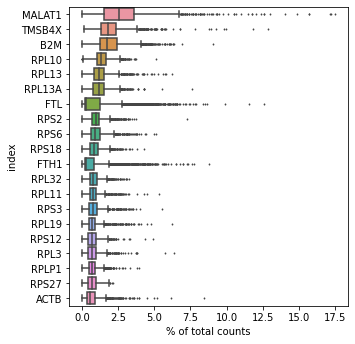

In [6]:
# look at highly expressed genes in the cell. 
sc.pl.highest_expr_genes(adata, n_top=20, )

## 2. Filter low quality reads

Dead cells likely have ruptured cell membranes and have leaked their mRNA content, leading to low overall mRNA counts read in the count matrix. We will filter these cells out. Additionally, genes found in fewer than 2-3 cells are filtered to reduce computational overhead and filter cells for whom noise may be an issue:

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

##### Filter cells with high no. mitochondrial reads

Dataset quality is important for downstream analysis. Low quality reads that can arise from dead cells that have lysed and contain only remnants of mitochondrial RNA. These cells will have a high percentage of mitochondrial-annotated genes and may have a low count depth for genes of interest. Here, we'll filter out cells for whom mitochondrial reads are transcriptionally overrepresented.  Other QC methods not featured in this tutorial include doublet elimination, ambient RNA detection, and ribosomal RNA regression.

In [8]:
# generate new metadata 'var' that show all genes starting with MT- , aka our mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 

# calcaultes the precentage of all reads that are mitochondrial reads.
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

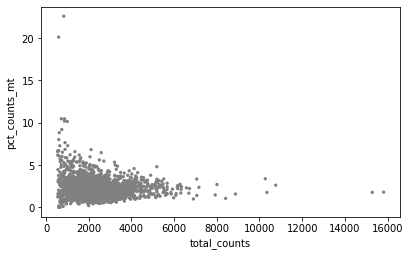

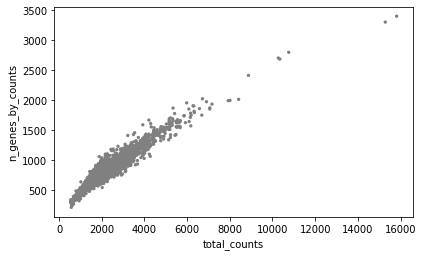

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
# filter out cells based on mitochondrial read percentage of greater than 5%.
adata = adata[adata.obs.pct_counts_mt < 5, :]

Filter out cells where total gene content is high, might represent doublets. Note that some labs do not recommend doublet removal in this fashion anymore because high count-cells might be biologically valuable/real. More sophisticated methods like Scrublet (https://github.com/swolock/scrublet) and scDblFinder (https://bioconductor.org/packages/release/bioc/html/scDblFinder.html) are now available, but we will not discuss those for the sake of time. 

In [11]:
# Roughly filter out doublets with the sledge hammer thresholding method
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

## 3. Normalize and scale reads for downstream expression analysis

We will normalize counts to 10000 sequencing reads per cell to allow for downstream between-cell comparisons. That is, we are making the assumption that all cells should produce roughly the same number of transcripts. With similar cell types this might be a safe assumption. Under what experimental conditions may it not be?


We will then log scale the data. 

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


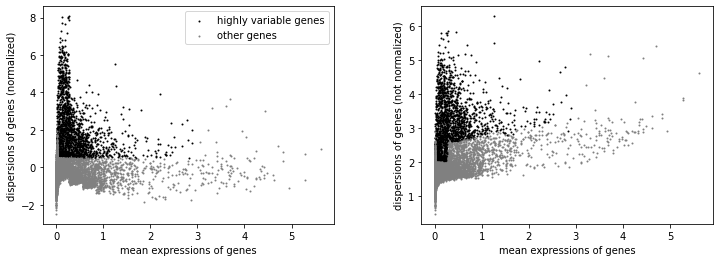

In [13]:
# take a look at the normalized v unnormalized data: 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

## 4. Save your work and pre-PCA steps

Save the raw normalized/scaled data for downstream differential expression analysis and gene expression visualization. This will maintain the original state of the Anndata object while we select a set of highly variable genes off of which to base our dimensionality reduction projects. This helps to reduce computational overhead, though with a dataset this small it is of minimal importance.

In [14]:
# Save raw expression values before variable gene subset
adata.raw = adata

In [15]:
# find highly variable genes in the dataset (calculated above) and subset the data
adata = adata[:, adata.var.highly_variable]

# regress out the effects of total RNA counts and the <5% mitochondrial reads in case this impacts our data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

We will scale our data to unit variance before principal components analysis is performed.

In [16]:
sc.pp.scale(adata, max_value=10)

## 5. Principal component analysis and UMAP visualizations

We will reveal the low dimensional embedding spaces along which the data varies the most. This will enable higher fidelity clustering and cell-type assignments.

In [17]:
# perform PCA using partial singular value decomposition algorithm ARPACK, you might have used this in the Scipy package
sc.tl.pca(adata, svd_solver='arpack')

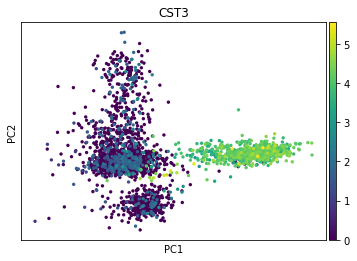

In [18]:
sc.pl.pca(adata, color=['CST3'])

You can view the relative importance of each PC in dataset below. **Can you ballpark how many major cell types are in the dataet based off of the PC1/2 graph and the elbow plot below?**

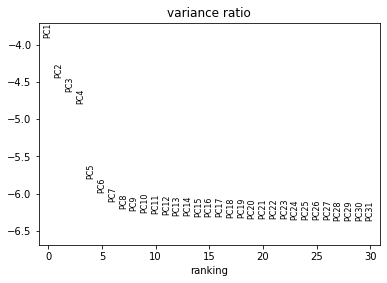

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 6. Compute neighborhood graph and visualize UMAP

We'll visualize cell clusters with UMAP projects.

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
## can see what TCFs, CDs, or ILs are overrepresented in the data

TCFs = [] # transcription factors
CDs = [] # cluster of differentiation extracellular marker
ILs = [] # common t cell signalers

for gene in adata.raw.var["gene_ids"].index:    # omit .raw if you want to focus on highly variable genes only.
    if gene.startswith("TCF"):
        TCFs.append(gene)
    elif gene.startswith("CD"):
        CDs.append(gene)
    elif gene.startswith("IL"):
        ILs.append(gene)

In [23]:
# TCFs

In [24]:
# CDs

In [25]:
# ILs

## 7. Manual identification of cell types

Cell type identification post-dimensionality reduction is an important step in identifying rare cell types, cell types of interest, or overall organism/sub community cell state. Here, we will annotate cell types by canonical cell-surface markers used by immunologists, available at https://www.celltypist.org/encyclopedia/Immune/v2/. Common PBMC cell types include T cells, B cells, Monocytes, natural killer cells, dendritic cells. We will also explore rarer megakaryocytes.

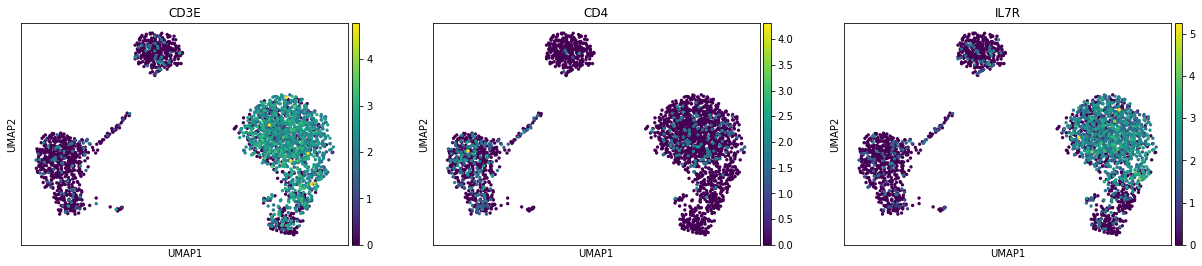

In [26]:
# CD4 cells
sc.pl.umap(adata, color=['CD3E', 'CD4', 'IL7R'], ncols = 3)

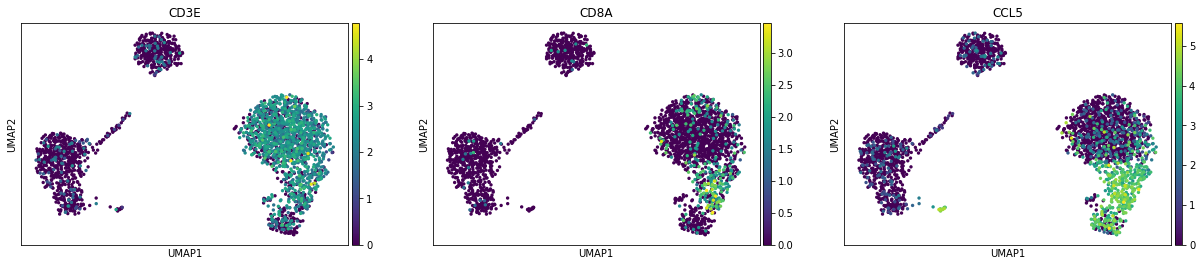

In [27]:
# CD8 cells
sc.pl.umap(adata, color=['CD3E', 'CD8A', 'CCL5'], ncols = 3)

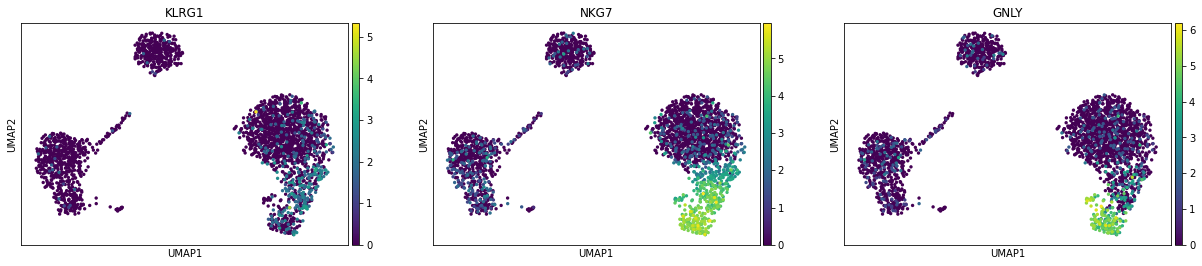

In [28]:
# NKs
sc.pl.umap(adata, color=['KLRG1', 'NKG7', 'GNLY'], ncols = 3)

Based off of the last two sets of cell marker expression maps, what might you infer about the relationship between NK/CD8 function?

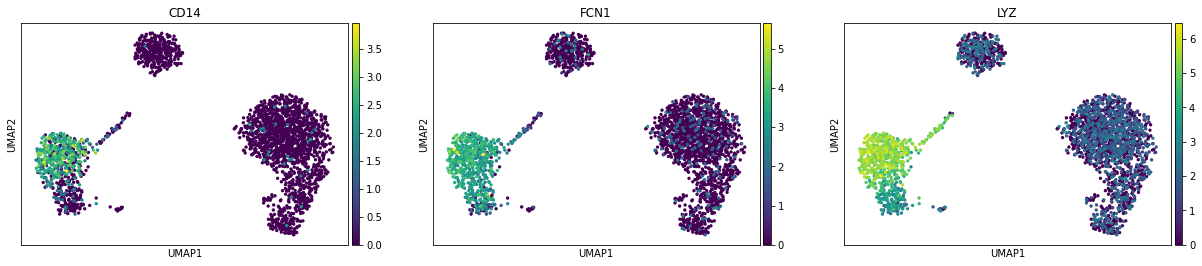

In [29]:
# CD14+ monocytes
sc.pl.umap(adata, color=['CD14', 'FCN1', 'LYZ'], ncols = 3)

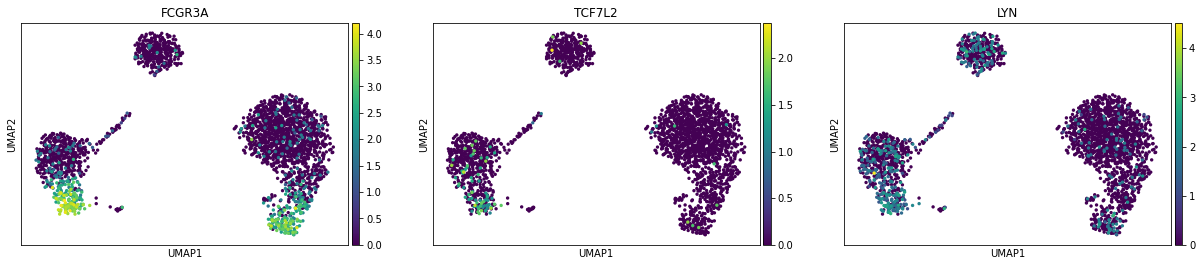

In [30]:
# CD16+ monocytes
sc.pl.umap(adata, color=['FCGR3A', 'TCF7L2', 'LYN'], ncols = 3)

The monocyte fraction becomes pretty obvious here.

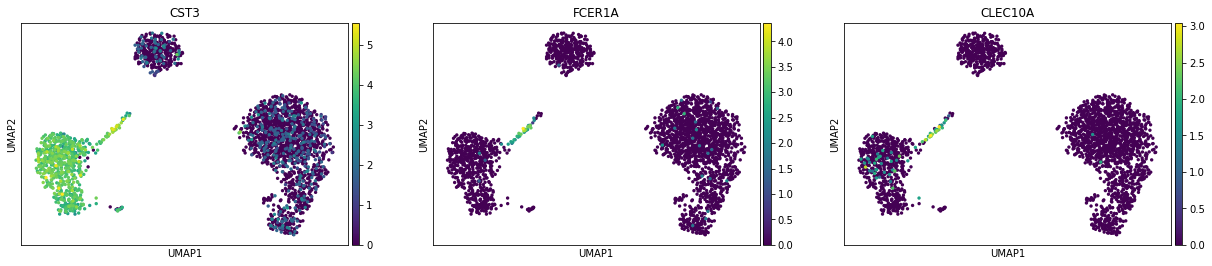

In [31]:
# Dendritic cells, professional antigen presenters
sc.pl.umap(adata, color=['CST3', 'FCER1A', 'CLEC10A'], ncols = 3)

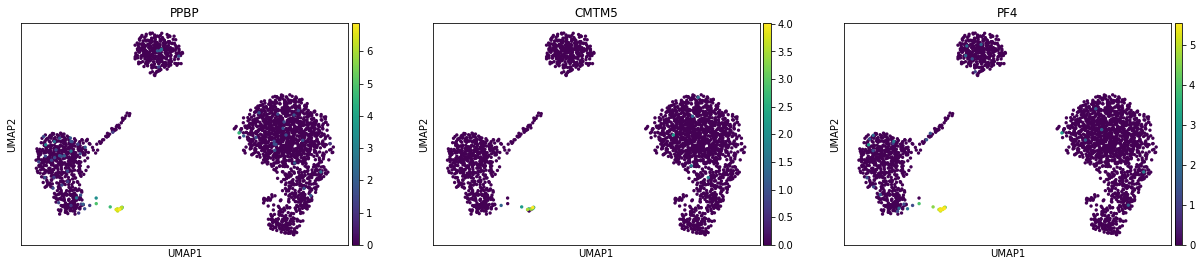

In [32]:
# Megakaryocytes/Platelets
sc.pl.umap(adata, color=['PPBP', 'CMTM5', 'PF4'], ncols = 3)

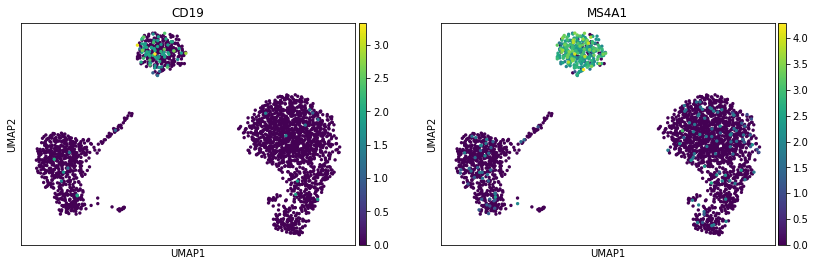

In [34]:
# B cells
sc.pl.umap(adata, color=['CD19', 'MS4A1'], ncols = 2)

## 8. Cluster assignment

Now that we have explored well-known canonical PBMC cell type markers, lets assign cell clusters.

We will detect cell clusters using community detection methods outlined by Traag *et al.* in https://arxiv.org/abs/1810.08473. We use the Leiden K-nearest neighbor graph algorithm to find a partition that optimally assigns cell type. Image courtesy of community RNAseq book (https://www.sc-best-practices.org/cellular_structure/clustering.html).

![KNN Leiden](https://www.sc-best-practices.org/_images/clustering.jpeg)

/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


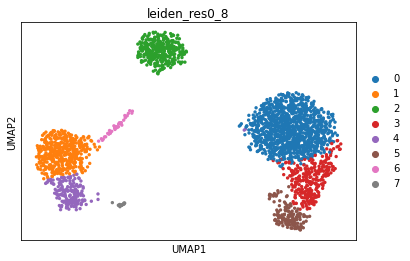

In [35]:
sc.tl.leiden(adata, key_added="leiden_res0_8", resolution=0.8)
sc.pl.umap(adata, color='leiden_res0_8', ncols = 2)

Now that we have tenable clusters, we can assign based off of our observations from the manual expression searchers performed above.

In [38]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'CD16+ Monocytes', 'NK',
    'Dendritic Cells', 'Megakaryocytes']
adata.rename_categories('leiden_res0_8', new_cluster_names)

/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


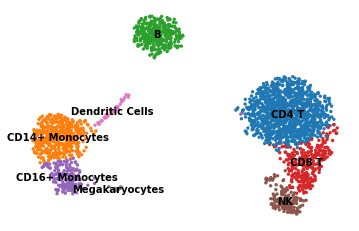

In [39]:
sc.pl.umap(adata, color='leiden_res0_8', legend_loc='on data', title='', frameon=False)

## 9. Optional multi-resolution Leiden graphs and automated identification of cell types

We will tune the $\gamma$ resolution parameter, where higher resolution ($\gamma > 0$) increases the number of detected communities.

In [40]:
# calculate no communities detected in UMAP1/2 embedding space.

sc.tl.leiden(adata, key_added="leiden_res0_2", resolution=0.2)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res0_8", resolution=0.8)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/averyp2/miniconda3/envs/med263project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


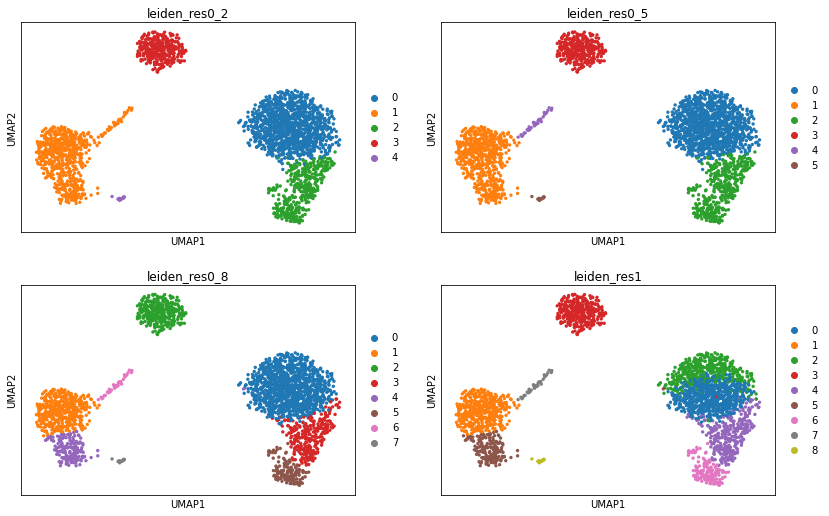

In [41]:
sc.pl.umap(adata, color=['leiden_res0_2', 'leiden_res0_5', 'leiden_res0_8', 'leiden_res1'], ncols = 2)

**Which resolution do you think best separates clusters?** Keep in mind that leukocyte subset lineage development is better represented by a spectrum rather than clear-cut cell types.

We can now rank highly differentially expressed genes in each cluster to try to identify which cell types they represent.

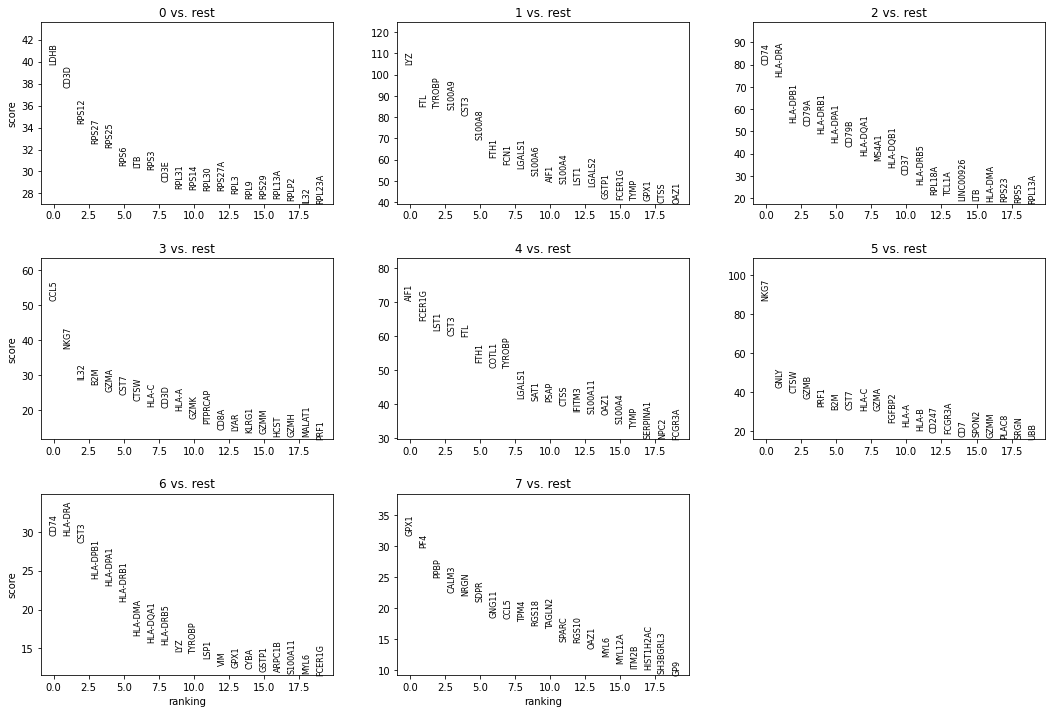

In [42]:
sc.tl.rank_genes_groups(adata, 'leiden_res0_8', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols = 3)

**What are the costs and benefits of identifying cell types with this more automated per-cluster elbow plot method? Do you find that the top per-cluster highly variable genes are actually good at identifying cell types? How does this relate to the `highly_variable_genes` question posed at the beginning of the tutorial?**

##### More resources: 

For more on supervised/automated clustering and cell marker annotation methods, see https://www.nature.com/articles/s41467-022-28803-w.